In [1]:
from denoising_diffusion_pytorch.denoising_diffusion_pytorch_1d_guided_embd import Unet1D, GaussianDiffusion1D, Trainer1D, Dataset1D
import sys
sys.path.append("../")
from param_dataset import *
from datasets import *

from robustbench.utils import clean_accuracy
from robustbench.utils import load_model
from torch.utils.data import DataLoader
import torch.nn as nn
sys.path.append("../finetuning")
from finetuning.train import validate
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from tqdm import tqdm
from collections import OrderedDict

def put_back_params(model,params):
    params = params.view(-1)
    with torch.no_grad():
        weights = params[:len(params)//2]
        biases = params[len(params)//2:]
        model.bn1.weight[:] = weights[:]
        model.bn1.bias[:] = biases[:]
        return model

corrs = ["frost", "gaussian_noise", "glass_blur", "contrast", "pixelate"]

model = Unet1D(
    dim = 32,
    dim_mults = (1, 2, 2, 2),
    channels = 8,
    num_classes = 5,
    cond_drop_prob = 0.2
)
# print(sum(p.numel() for p in model.parameters() if p.requires_grad)/1000000)
# exit()

diffusion = GaussianDiffusion1D(
    model,
    seq_length = 160,
    timesteps = 1000,
    objective = 'pred_noise',
    auto_normalize=False
)

root_path = os.path.expanduser(f"~/Projects/GenAIProject/saved_data/checkpoints/gen_last_bn_eval_diverse/")
dataset = ParamDataset(root_path,conditional=False,corr_list=corrs,embd_cond=True)

trainer = Trainer1D(
    diffusion,
    dataset = dataset,
    corruptions = corrs,
    train_batch_size = 64,
    train_lr = 3e-4,
    train_num_steps = 5000,         # total training steps
    gradient_accumulate_every = 1,    # gradient accumulation steps
    ema_decay = 0.999,                # exponential moving average decay
    amp = True,                       # turn on mixed precision
    results_folder=f'cond_embd_results/'
)

/home/gc28692/anaconda3/envs/ttda/lib/python3.9/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(split_batches=True)
  warnings.warn(


In [3]:
trainer.load(5)

loading from version 1.11.0


In [2]:
import copy

finetune all

In [16]:
corrs = ["clean","gaussian_noise","shot_noise","impulse_noise", 
		"defocus_blur","glass_blur","motion_blur","zoom_blur",
		"snow","frost", "fog",
		"brightness", "contrast","elastic_transform","pixelate","jpeg_compression"]
accs = {corr : [] for corr in corrs}
aug_accs = {corr : [] for corr in corrs}

og_model = load_model(model_name='Standard',dataset='cifar10',threat_model='corruptions').eval().cuda()
og_params = OrderedDict((key, value.cpu()) for key, value in og_model.state_dict().items() if key in ['bn1.weight','bn1.bias'])
og_params = torch.cat([param.flatten() for param in og_params.values()])

for corr_i,corr in enumerate(corrs):
	test_model = load_model(model_name='Standard',dataset='cifar10',threat_model='corruptions').eval().cuda()
	
	# get data for specific corruption
	if corr == 'clean':
		x_clean, y_clean = x_clean,y_clean = load_cifar10(500)
		test_ds = TensorDataset(x_clean,y_clean)
		aug_model = copy.deepcopy(test_model)
	else:
		root_path = f"~/Projects/GenAIProject/saved_data/checkpoints/gen_last_bn_eval_diverse_all/"
		paths = os.listdir(os.path.expanduser(os.path.join(root_path,'all')))
		model_path = os.path.expanduser(os.path.join(root_path,'all',paths[0]))
		params = torch.load(model_path)
		aug_model = copy.deepcopy(test_model)
		aug_model.load_state_dict(torch.load(model_path)['model_state_dict'],strict=False)
		aug_model = aug_model.eval()
		train_ds, val_ds, test_ds = get_cifar10c_data([corrs[corr_i]],1000)
		#test_ds = Subset(test_ds,torch.arange(2000))
	
	dl_t = DataLoader(test_ds,batch_size=256)
	num_correct = 0
	aug_num_correct = 0
	total = 0
	
	# aug model
	
	with torch.no_grad():
		predictions = []
		labels = []
		outputs = []
		predictions_ = []
		labels_ = []
		outputs_ = []
		for batch_idx, (data,target) in enumerate(tqdm(dl_t)):
			data,target = data.to('cuda'),target.to('cuda')

			# og model
			out = test_model(data)
			pred = out.argmax(dim=1).to('cpu')
			predictions.append(pred)
			labels.append(target.to('cpu'))
			outputs.append(out.to('cpu'))
			# print(pred.shape,target.shape)
			# num_correct += (pred == target.to('cpu'))

			out = aug_model(data)
			pred = out.argmax(dim=1).to('cpu')
			predictions_.append(pred)
			labels_.append(target.to('cpu'))
			outputs_.append(out.to('cpu'))
			# aug_num_correct += (pred == target.to('cpu'))
			# total += 1

	predictions = torch.cat(predictions).numpy()
	labels = torch.cat(labels).numpy()
	outputs = torch.cat(outputs)
	predictions_ = torch.cat(predictions_).numpy()
	labels_ = torch.cat(labels_).numpy()
	outputs_ = torch.cat(outputs_)
	acc = (predictions == labels).mean()
	aug_acc = (predictions_ == labels_).mean()
	
	print(f"Acc for {corr} = (before) {acc}, (after) {aug_acc}, improvement: {aug_acc-acc}")
	accs[corr].append(acc.item())
	aug_accs[corr].append(aug_acc.item())

Files already downloaded and verified


100%|██████████| 2/2 [00:00<00:00,  4.86it/s]


Acc for clean = (before) 0.946, (after) 0.946, improvement: 0.0


100%|██████████| 35/35 [00:07<00:00,  4.90it/s]


Acc for gaussian_noise = (before) 0.2771590909090909, (after) 0.42556818181818185, improvement: 0.14840909090909093


100%|██████████| 35/35 [00:07<00:00,  4.90it/s]


Acc for shot_noise = (before) 0.3405681818181818, (after) 0.4847727272727273, improvement: 0.14420454545454547


100%|██████████| 35/35 [00:07<00:00,  4.87it/s]


Acc for impulse_noise = (before) 0.27045454545454545, (after) 0.27340909090909093, improvement: 0.0029545454545454874


100%|██████████| 35/35 [00:07<00:00,  4.87it/s]


Acc for defocus_blur = (before) 0.5336363636363637, (after) 0.54375, improvement: 0.01011363636363627


100%|██████████| 35/35 [00:07<00:00,  4.87it/s]


Acc for glass_blur = (before) 0.4551136363636364, (after) 0.5364772727272727, improvement: 0.08136363636363636


100%|██████████| 35/35 [00:07<00:00,  4.87it/s]


Acc for motion_blur = (before) 0.6528409090909091, (after) 0.66, improvement: 0.007159090909090948


100%|██████████| 35/35 [00:07<00:00,  4.87it/s]


Acc for zoom_blur = (before) 0.5792045454545455, (after) 0.5613636363636364, improvement: -0.017840909090909074


100%|██████████| 35/35 [00:07<00:00,  4.86it/s]


Acc for snow = (before) 0.74875, (after) 0.7794318181818182, improvement: 0.030681818181818143


100%|██████████| 35/35 [00:07<00:00,  4.86it/s]


Acc for frost = (before) 0.585, (after) 0.6802272727272727, improvement: 0.09522727272727272


100%|██████████| 35/35 [00:07<00:00,  4.86it/s]


Acc for fog = (before) 0.7392045454545455, (after) 0.7602272727272728, improvement: 0.02102272727272725


100%|██████████| 35/35 [00:07<00:00,  4.86it/s]


Acc for brightness = (before) 0.9079545454545455, (after) 0.8923863636363636, improvement: -0.01556818181818187


100%|██████████| 35/35 [00:07<00:00,  4.86it/s]


Acc for contrast = (before) 0.5336363636363637, (after) 0.6, improvement: 0.06636363636363629


100%|██████████| 35/35 [00:07<00:00,  4.84it/s]


Acc for elastic_transform = (before) 0.7320454545454546, (after) 0.7047727272727272, improvement: -0.027272727272727337


100%|██████████| 35/35 [00:07<00:00,  4.84it/s]


Acc for pixelate = (before) 0.415, (after) 0.5126136363636363, improvement: 0.09761363636363635


100%|██████████| 35/35 [00:07<00:00,  4.84it/s]

Acc for jpeg_compression = (before) 0.6973863636363636, (after) 0.6659090909090909, improvement: -0.03147727272727274


finetune single

In [15]:
corrs = ["clean","gaussian_noise","shot_noise","impulse_noise", 
		"defocus_blur","glass_blur","motion_blur","zoom_blur",
		"snow","frost", "fog",
		"brightness", "contrast","elastic_transform","pixelate","jpeg_compression"]
accs = {corr : [] for corr in corrs}
aug_accs = {corr : [] for corr in corrs}

og_model = load_model(model_name='Standard',dataset='cifar10',threat_model='corruptions').eval().cuda()
og_params = OrderedDict((key, value.cpu()) for key, value in og_model.state_dict().items() if key in ['bn1.weight','bn1.bias'])
og_params = torch.cat([param.flatten() for param in og_params.values()])

for corr_i,corr in enumerate(corrs):
	test_model = load_model(model_name='Standard',dataset='cifar10',threat_model='corruptions').eval().cuda()
	
	# get data for specific corruption
	if corr == 'clean':
		x_clean, y_clean = x_clean,y_clean = load_cifar10(500)
		test_ds = TensorDataset(x_clean,y_clean)
		aug_model = copy.deepcopy(test_model)
	else:
		root_path = f"~/Projects/GenAIProject/saved_data/checkpoints/gen_last_bn_eval_diverse_single/"
		paths = os.listdir(os.path.expanduser(os.path.join(root_path,corr)))
		model_path = os.path.expanduser(os.path.join(root_path,corr,paths[0]))
		params = torch.load(model_path)
		aug_model = copy.deepcopy(test_model)
		aug_model.load_state_dict(torch.load(model_path)['model_state_dict'],strict=False)
		aug_model = aug_model.eval()
		train_ds, val_ds, test_ds = get_cifar10c_data([corrs[corr_i]],1000)
		#test_ds = Subset(test_ds,torch.arange(2000))
	
	dl_t = DataLoader(test_ds,batch_size=256)
	num_correct = 0
	aug_num_correct = 0
	total = 0
	
	# aug model
	
	with torch.no_grad():
		predictions = []
		labels = []
		outputs = []
		predictions_ = []
		labels_ = []
		outputs_ = []
		for batch_idx, (data,target) in enumerate(tqdm(dl_t)):
			data,target = data.to('cuda'),target.to('cuda')

			# og model
			out = test_model(data)
			pred = out.argmax(dim=1).to('cpu')
			predictions.append(pred)
			labels.append(target.to('cpu'))
			outputs.append(out.to('cpu'))
			# print(pred.shape,target.shape)
			# num_correct += (pred == target.to('cpu'))

			out = aug_model(data)
			pred = out.argmax(dim=1).to('cpu')
			predictions_.append(pred)
			labels_.append(target.to('cpu'))
			outputs_.append(out.to('cpu'))
			# aug_num_correct += (pred == target.to('cpu'))
			# total += 1

	predictions = torch.cat(predictions).numpy()
	labels = torch.cat(labels).numpy()
	outputs = torch.cat(outputs)
	predictions_ = torch.cat(predictions_).numpy()
	labels_ = torch.cat(labels_).numpy()
	outputs_ = torch.cat(outputs_)
	acc = (predictions == labels).mean()
	aug_acc = (predictions_ == labels_).mean()
	
	print(f"Acc for {corr} = (before) {acc}, (after) {aug_acc}, improvement: {aug_acc-acc}")
	accs[corr].append(acc.item())
	aug_accs[corr].append(aug_acc.item())

Files already downloaded and verified


100%|██████████| 2/2 [00:00<00:00,  4.87it/s]


Acc for clean = (before) 0.946, (after) 0.946, improvement: 0.0


100%|██████████| 35/35 [00:07<00:00,  4.89it/s]


Acc for gaussian_noise = (before) 0.2771590909090909, (after) 0.49022727272727273, improvement: 0.21306818181818182


100%|██████████| 35/35 [00:07<00:00,  4.88it/s]


Acc for shot_noise = (before) 0.3405681818181818, (after) 0.509090909090909, improvement: 0.1685227272727272


100%|██████████| 35/35 [00:07<00:00,  4.87it/s]


Acc for impulse_noise = (before) 0.27045454545454545, (after) 0.35818181818181816, improvement: 0.08772727272727271


100%|██████████| 35/35 [00:07<00:00,  4.87it/s]


Acc for defocus_blur = (before) 0.5336363636363637, (after) 0.6580681818181818, improvement: 0.12443181818181814


100%|██████████| 35/35 [00:07<00:00,  4.80it/s]


Acc for glass_blur = (before) 0.4551136363636364, (after) 0.5693181818181818, improvement: 0.11420454545454545


100%|██████████| 35/35 [00:07<00:00,  4.86it/s]


Acc for motion_blur = (before) 0.6528409090909091, (after) 0.7373863636363637, improvement: 0.08454545454545459


100%|██████████| 35/35 [00:07<00:00,  4.86it/s]


Acc for zoom_blur = (before) 0.5792045454545455, (after) 0.6890909090909091, improvement: 0.10988636363636362


100%|██████████| 35/35 [00:07<00:00,  4.86it/s]


Acc for snow = (before) 0.74875, (after) 0.7763636363636364, improvement: 0.02761363636363634


100%|██████████| 35/35 [00:07<00:00,  4.86it/s]


Acc for frost = (before) 0.585, (after) 0.7080681818181818, improvement: 0.1230681818181818


100%|██████████| 35/35 [00:07<00:00,  4.86it/s]


Acc for fog = (before) 0.7392045454545455, (after) 0.8042045454545454, improvement: 0.06499999999999995


100%|██████████| 35/35 [00:07<00:00,  4.86it/s]


Acc for brightness = (before) 0.9079545454545455, (after) 0.9082954545454546, improvement: 0.0003409090909091139


100%|██████████| 35/35 [00:07<00:00,  4.86it/s]


Acc for contrast = (before) 0.5336363636363637, (after) 0.6557954545454545, improvement: 0.12215909090909083


100%|██████████| 35/35 [00:07<00:00,  4.84it/s]


Acc for elastic_transform = (before) 0.7320454545454546, (after) 0.7609090909090909, improvement: 0.028863636363636314


100%|██████████| 35/35 [00:07<00:00,  4.84it/s]


Acc for pixelate = (before) 0.415, (after) 0.6119318181818182, improvement: 0.1969318181818182


100%|██████████| 35/35 [00:07<00:00,  4.84it/s]

Acc for jpeg_compression = (before) 0.6973863636363636, (after) 0.7193181818181819, improvement: 0.02193181818181822


diffusion

In [4]:
corrs = ["clean","gaussian_noise","shot_noise","impulse_noise", 
        "defocus_blur","glass_blur","motion_blur","zoom_blur",
        "snow","frost", "fog",
        "brightness", "contrast","elastic_transform","pixelate","jpeg_compression"]
accs = {corr : [] for corr in corrs}
aug_accs = {corr : [] for corr in corrs}

og_model = load_model(model_name='Standard',dataset='cifar10',threat_model='corruptions').eval().cuda()
og_params = OrderedDict((key, value.cpu()) for key, value in og_model.state_dict().items() if key in ['bn1.weight','bn1.bias'])
og_params = torch.cat([param.flatten() for param in og_params.values()])

for corr_i,corr in enumerate(corrs):
    test_model = load_model(model_name='Standard',dataset='cifar10',threat_model='corruptions').eval().cuda()
    
    # get data for specific corruption
    if corr == 'clean':
        x_clean, y_clean = x_clean,y_clean = load_cifar10(1000)
        test_ds = TensorDataset(x_clean,y_clean)
    else:
        train_ds, val_ds, test_ds = get_cifar10c_data([corrs[corr_i]],1000)
        test_ds = Subset(test_ds,torch.arange(1000))
    dl_t = DataLoader(test_ds,batch_size=512)

    # add a hook to the model to get the activations right before bn
    test_model.bn1.register_forward_hook(get_activation('bn1'))

    generated_params = []
    # for every sample, collect the activations and then pass through diff model
    with torch.no_grad():
        for batch_idx, (data,target) in enumerate(tqdm(dl_t)):
            # parse the batch and send to device
            data,target = data.to('cuda'),target.to('cuda')

            # forward pass
            out = test_model(data)
            input_activations = activations['bn1']

            # get the diffusion outputs for these embeddings
            # cat_params = copy.deepcopy(og_params)
            # cat_params = cat_params.unsqueeze(0).repeat(input_activations.shape[0], 1)
            # input_activations = torch.cat([input_activations,cat_params.cuda()],dim=1)
            generated_params.append(trainer.model.sample(input_activations, cond_scale=3.))

    generated_params = torch.cat(generated_params)
    
    dl_t = DataLoader(test_ds,batch_size=1)
    num_correct = 0
    aug_num_correct = 0
    total = 0
    aug_model = copy.deepcopy(test_model)
    with torch.no_grad():
        for batch_idx, (data,target) in enumerate(tqdm(dl_t)):
            data,target = data.to('cuda'),target.to('cuda')

            # og model
            out = test_model(data)
            pred = out.argmax(dim=1).to('cpu')
            num_correct += (pred == target.to('cpu'))

            # aug model
            params = generated_params[batch_idx]
            aug_model = put_back_params(aug_model,params)
            aug_model = aug_model.eval()

            out = aug_model(data)
            pred = out.argmax(dim=1).to('cpu')
            aug_num_correct += (pred == target.to('cpu'))
            total += 1

    acc = num_correct/total
    aug_acc = aug_num_correct/total
    
    print(f"Acc for {corr} = (before) {acc}, (after) {aug_acc}, improvement: {aug_acc-acc}")
    accs[corr].append(acc.item())
    aug_accs[corr].append(aug_acc.item())

Files already downloaded and verified


  0%|          | 0/2 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:33<00:33, 33.88s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 278.55it/s]


Acc for clean = (before) tensor([0.9480]), (after) tensor([0.9300]), improvement: tensor([-0.0180])


  0%|          | 0/2 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:33<00:33, 33.12s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 277.73it/s]


Acc for gaussian_noise = (before) tensor([0.2790]), (after) tensor([0.4380]), improvement: tensor([0.1590])


  0%|          | 0/2 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:33<00:33, 33.13s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 275.15it/s]


Acc for shot_noise = (before) tensor([0.3550]), (after) tensor([0.4820]), improvement: tensor([0.1270])


  0%|          | 0/2 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:33<00:33, 33.13s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 279.18it/s]


Acc for impulse_noise = (before) tensor([0.2760]), (after) tensor([0.2800]), improvement: tensor([0.0040])


  0%|          | 0/2 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:33<00:33, 33.11s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 279.95it/s]


Acc for defocus_blur = (before) tensor([0.5340]), (after) tensor([0.5600]), improvement: tensor([0.0260])


  0%|          | 0/2 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:33<00:33, 33.16s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 279.71it/s]


Acc for glass_blur = (before) tensor([0.4650]), (after) tensor([0.5600]), improvement: tensor([0.0950])


  0%|          | 0/2 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:33<00:33, 33.21s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 278.64it/s]


Acc for motion_blur = (before) tensor([0.6500]), (after) tensor([0.6930]), improvement: tensor([0.0430])


  0%|          | 0/2 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:33<00:33, 33.06s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 278.55it/s]


Acc for zoom_blur = (before) tensor([0.5760]), (after) tensor([0.5870]), improvement: tensor([0.0110])


  0%|          | 0/2 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:33<00:33, 33.08s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 278.78it/s]


Acc for snow = (before) tensor([0.7590]), (after) tensor([0.7670]), improvement: tensor([0.0080])


  0%|          | 0/2 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:33<00:33, 33.12s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 277.91it/s]


Acc for frost = (before) tensor([0.6170]), (after) tensor([0.7070]), improvement: tensor([0.0900])


  0%|          | 0/2 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:33<00:33, 33.09s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 277.58it/s]


Acc for fog = (before) tensor([0.7490]), (after) tensor([0.7730]), improvement: tensor([0.0240])


  0%|          | 0/2 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:33<00:33, 33.11s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 279.06it/s]


Acc for brightness = (before) tensor([0.9090]), (after) tensor([0.8860]), improvement: tensor([-0.0230])


  0%|          | 0/2 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:33<00:33, 33.12s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 280.35it/s]


Acc for contrast = (before) tensor([0.5290]), (after) tensor([0.6360]), improvement: tensor([0.1070])


  0%|          | 0/2 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:33<00:33, 33.07s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 274.25it/s]


Acc for elastic_transform = (before) tensor([0.7260]), (after) tensor([0.7270]), improvement: tensor([0.0010])


  0%|          | 0/2 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:33<00:33, 33.09s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 276.33it/s]


Acc for pixelate = (before) tensor([0.4080]), (after) tensor([0.5830]), improvement: tensor([0.1750])


  0%|          | 0/2 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:33<00:33, 33.11s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 276.26it/s]

Acc for jpeg_compression = (before) tensor([0.7180]), (after) tensor([0.6780]), improvement: tensor([-0.0400])


diffusion ensemble

In [14]:
corrs = ["clean","gaussian_noise","shot_noise","impulse_noise", 
        "defocus_blur","glass_blur","motion_blur","zoom_blur",
        "snow","frost", "fog",
        "brightness", "contrast","elastic_transform","pixelate","jpeg_compression"]
accs = {corr : [] for corr in corrs}
aug_accs = {corr : [] for corr in corrs}

og_model = load_model(model_name='Standard',dataset='cifar10',threat_model='corruptions').eval().cuda()
og_params = OrderedDict((key, value.cpu()) for key, value in og_model.state_dict().items() if key in ['bn1.weight','bn1.bias'])
og_params = torch.cat([param.flatten() for param in og_params.values()])

for corr_i,corr in enumerate(corrs):
    test_model = load_model(model_name='Standard',dataset='cifar10',threat_model='corruptions').eval().cuda()
    
    # get data for specific corruption
    if corr == 'clean':
        x_clean, y_clean = x_clean,y_clean = load_cifar10(1000)
        test_ds = TensorDataset(x_clean,y_clean)
    else:
        train_ds, val_ds, test_ds = get_cifar10c_data([corrs[corr_i]],1000)
        test_ds = Subset(test_ds,torch.arange(1000))
    dl_t = DataLoader(test_ds,batch_size=512)

    # add a hook to the model to get the activations right before bn
    test_model.bn1.register_forward_hook(get_activation('bn1'))

    generated_params1 = []
    generated_params2 = []
    generated_params3 = []
    # for every sample, collect the activations and then pass through diff model
    with torch.no_grad():
        for batch_idx, (data,target) in enumerate(tqdm(dl_t)):
            # parse the batch and send to device
            data,target = data.to('cuda'),target.to('cuda')

            # forward pass
            out = test_model(data)
            input_activations = activations['bn1']

            # get the diffusion outputs for these embeddings
            # cat_params = copy.deepcopy(og_params)
            # cat_params = cat_params.unsqueeze(0).repeat(input_activations.shape[0], 1)
            # input_activations = torch.cat([input_activations,cat_params.cuda()],dim=1)
            generated_params1.append(trainer.model.sample(input_activations, cond_scale=3.))
            generated_params2.append(trainer.model.sample(input_activations, cond_scale=3.))
            generated_params3.append(trainer.model.sample(input_activations, cond_scale=3.))

    generated_params1 = torch.cat(generated_params1)
    generated_params2 = torch.cat(generated_params2)
    generated_params3 = torch.cat(generated_params3)
    gps = [generated_params1,generated_params2,generated_params3]
    
    dl_t = DataLoader(test_ds,batch_size=1)
    num_correct = 0
    aug_num_correct = 0
    total = 0
    aug_model = copy.deepcopy(test_model)
    with torch.no_grad():
        for batch_idx, (data,target) in enumerate(tqdm(dl_t)):
            data,target = data.to('cuda'),target.to('cuda')

            # og model
            out = test_model(data)
            pred = out.argmax(dim=1).to('cpu')
            num_correct += (pred == target.to('cpu'))

            # aug model
            ens_preds = []
            for ens_i in range(3):
                params = gps[ens_i][batch_idx]
                aug_model = put_back_params(aug_model,params)
                aug_model = aug_model.eval()

                out = F.softmax(aug_model(data),dim=1)
                ens_preds.append(out)
            ens_pred = torch.mean(torch.cat(ens_preds,dim=0),dim=0)
            pred = ens_pred.argmax().to('cpu')
            aug_num_correct += (pred == target.to('cpu'))
            total += 1

    acc = num_correct/total
    aug_acc = aug_num_correct/total
    
    print(f"Acc for {corr} = (before) {acc}, (after) {aug_acc}, improvement: {aug_acc-acc}")
    accs[corr].append(acc.item())
    aug_accs[corr].append(aug_acc.item())

Files already downloaded and verified


  0%|          | 0/2 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 1/2 [01:38<01:38, 98.76s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:07<00:00, 138.78it/s]


Acc for clean = (before) tensor([0.9480]), (after) tensor([0.9340]), improvement: tensor([-0.0140])


  0%|          | 0/2 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 1/2 [01:39<01:39, 99.14s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:07<00:00, 139.23it/s]


Acc for gaussian_noise = (before) tensor([0.2790]), (after) tensor([0.4650]), improvement: tensor([0.1860])


  0%|          | 0/2 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 1/2 [01:39<01:39, 99.13s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:07<00:00, 141.00it/s]


Acc for shot_noise = (before) tensor([0.3550]), (after) tensor([0.5120]), improvement: tensor([0.1570])


  0%|          | 0/2 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 1/2 [01:38<01:38, 98.99s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:06<00:00, 150.28it/s]


Acc for impulse_noise = (before) tensor([0.2760]), (after) tensor([0.3040]), improvement: tensor([0.0280])


  0%|          | 0/2 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 1/2 [01:38<01:38, 98.95s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:06<00:00, 150.09it/s]


Acc for defocus_blur = (before) tensor([0.5340]), (after) tensor([0.5650]), improvement: tensor([0.0310])


  0%|          | 0/2 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 1/2 [01:39<01:39, 99.01s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:06<00:00, 150.34it/s]


Acc for glass_blur = (before) tensor([0.4650]), (after) tensor([0.5630]), improvement: tensor([0.0980])


  0%|          | 0/2 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 1/2 [01:38<01:38, 98.96s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:06<00:00, 150.36it/s]


Acc for motion_blur = (before) tensor([0.6500]), (after) tensor([0.7140]), improvement: tensor([0.0640])


  0%|          | 0/2 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 1/2 [01:38<01:38, 98.99s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:06<00:00, 150.61it/s]


Acc for zoom_blur = (before) tensor([0.5760]), (after) tensor([0.6050]), improvement: tensor([0.0290])


  0%|          | 0/2 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 1/2 [01:39<01:39, 99.05s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:06<00:00, 150.52it/s]


Acc for snow = (before) tensor([0.7590]), (after) tensor([0.7680]), improvement: tensor([0.0090])


  0%|          | 0/2 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 1/2 [01:38<01:38, 98.98s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:06<00:00, 151.08it/s]


Acc for frost = (before) tensor([0.6170]), (after) tensor([0.7200]), improvement: tensor([0.1030])


  0%|          | 0/2 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 1/2 [01:38<01:38, 98.99s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:06<00:00, 151.54it/s]


Acc for fog = (before) tensor([0.7490]), (after) tensor([0.7910]), improvement: tensor([0.0420])


  0%|          | 0/2 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 1/2 [01:38<01:38, 99.00s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:06<00:00, 148.29it/s]


Acc for brightness = (before) tensor([0.9090]), (after) tensor([0.8910]), improvement: tensor([-0.0180])


  0%|          | 0/2 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 1/2 [01:38<01:38, 98.95s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:06<00:00, 149.62it/s]


Acc for contrast = (before) tensor([0.5290]), (after) tensor([0.6520]), improvement: tensor([0.1230])


  0%|          | 0/2 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 1/2 [01:38<01:38, 98.94s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:06<00:00, 150.36it/s]


Acc for elastic_transform = (before) tensor([0.7260]), (after) tensor([0.7300]), improvement: tensor([0.0040])


  0%|          | 0/2 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 1/2 [01:38<01:38, 98.98s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:06<00:00, 151.13it/s]


Acc for pixelate = (before) tensor([0.4080]), (after) tensor([0.5980]), improvement: tensor([0.1900])


  0%|          | 0/2 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 1/2 [01:38<01:38, 98.99s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:06<00:00, 150.81it/s]

Acc for jpeg_compression = (before) tensor([0.7180]), (after) tensor([0.6940]), improvement: tensor([-0.0240])


(-0.1, 0.3)

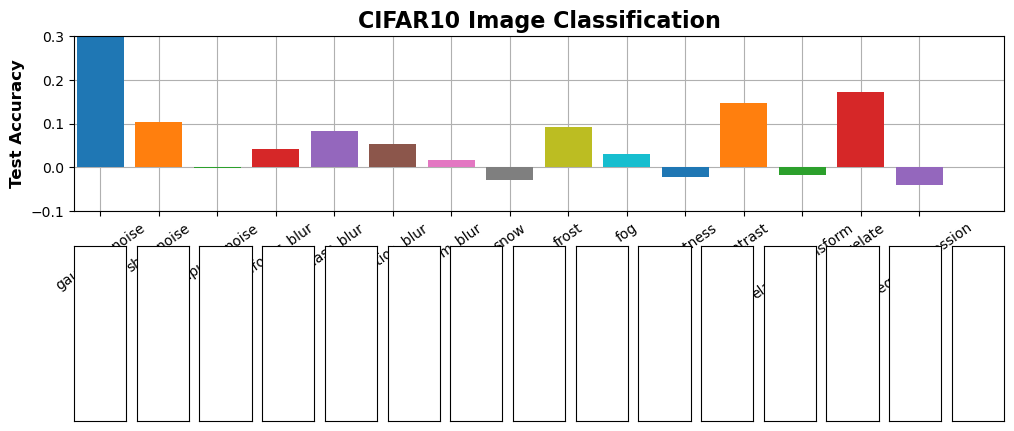

In [12]:
eval_results = copy.deepcopy(accs)
for corr in corrs[1:]:
    eval_results[corr] = aug_accs[corr][0]-accs[corr][0]

fig,ax = plt.subplot_mosaic([['bar']*15,#['bar','bar','bar','bar','bar','bar'],
                             CORRUPTIONS],
                             #['clean','frost','gaussian_noise','glass_blur','contrast','pixelate']],
                            figsize=(12,5))
x = list(eval_results.keys())
y = list(eval_results.values())

#corrs = ['clean','frost','gaussian_noise','glass_blur','contrast','pixelate']
corrs = CORRUPTIONS
for corr, val, in zip(x,y):
    if corr in corrs:
        ax['bar'].bar(corr,val)#,width = 0.75,align='center')
        # ax['bar'].set_xticks(corrs,corrs,fontsize=14, fontweight='bold')
        # ax['bar'].set_yticks(corrs,corrs,fontsize=14, fontweight='bold')
        margin = (1 - 0.1) + 0.1 / 2
        ax['bar'].set_xlim(-margin+0.5, 16 - 1 + margin-0.5)
        # if corr == 'clean':
        #     ax[corr].imshow(x_clean[10].permute(1,2,0))
        # else:
        #     idx = CORRUPTIONS.index(corr)
            # ax[corr].imshow(x_corr[10+10000*idx].permute(1,2,0))
        ax[corr].set_xticks([])
        ax[corr].set_yticks([])
        ax['bar'].tick_params(axis='x', rotation=35)
ax['bar'].grid()
ax['bar'].set_axisbelow(True)
ax['bar'].set_ylabel("Test Accuracy",fontsize=12,fontweight='bold')
ax['bar'].set_title("CIFAR10 Image Classification",fontsize=16,fontweight='bold')
ax['bar'].set_ylim((-0.1,0.30))